<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>
<h2 align='center'> Maria Apolo Rol: 201573509-3 </h1>
<h2 align='center'> Diego Gutierrez Rol: 201573558-1 </h1>
<h2 align='center'> Profesor: Ricardo Ñanculef </h1>
<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>


<a id="segundo"></a>
## 2. Problema de Múltiples Anotaciones

El aprendizaje supervisado visto en clases da cuenta que existe una única posible etiqueta $z$ (*ground truth*) asociada a un dato $x$ para poder aprender de los datos. Sin embargo, la definición del *ground truth* en algunos casos puede resultar bastante difícil de definir o bastante costoso, por ejemplo en problemas médicos donde se deben realizar invasivos exámenes para conocer la "verdad absoluta". Como alternativa se pueden recolectar múltiples anotaciones desde personas inexpertas en el área para poder estimar el *ground truth*. 

<img src="http://www.irishenvironment.com/wp-content/uploads/2013/11/crowdsourcing.jpg" title="Title text" width="40%" />

En esta actividad se trabajará en el caso en que contamos con múltiples anotaciones por cada dato de entrada $x_i$ dadas por personas inexpertas a través de Amazon Mechanical Turk (__[AMT](https://www.mturk.com/)__), es decir, $y^{(1)}, y^{(2)} \ldots y^{(T_i)}$. El problema de predicción trabajado será el mismo de la actividad anterior, el análisis de sentimiento de un extracto de texto en Rotten Tomatoes. Los datos trabajados [[8]](#refs) pueden ser descargados de la página del autor.
```
wget http://fprodrigues.com//mturk-datasets.tar.gz
```

De esta manera trabajaremos con el archivo *mturk_answers.csv* en la carpeta *sentiment polarity* que se puede cargar con pandas. En este archivo se tendrán múltiples filas/registros por cada dato de entrenamiento, cada uno representando la etiqueta que entregó una persona (*worker*) a ese dato, los detalles de columnas son:
* *WorkerId*: identificador de la persona que etiquetó/anotó el dato
* *Input.id*: identificador del dato a etiquetar/anotar
* *Input.original_sentence*: texto original del dato
* *Input.stemmed_sent*: texto pre-procesado
* *Input.true_sent*: sentimiento real (*ground truth*) del dato
* *Answer.sent*:   etiqueta/anotación que entregó la persona



> El objetivo de la actividad será el de obtener un modelo predictor del *ground truth* sin entrenar directamente con esto, sino que utilizar las múltiples anotaciones de las personas

### Importante
* Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento *ground truth* (sin repeticiones)
* Los valores de *ground truth* están **solo para evaluar**, no puede utilizarlos para entrenar o tomar decisiones en su modelo.
* La métrica de evaluación será el *accuracy score*
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```


In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("./mturk-datasets/sentiment_polarity/mturk_answers.csv")
print("Tamaño del dataframe",df.shape)
df.head()

Tamaño del dataframe (27746, 6)


,WorkerId,Input.id,Input.original_sentence,Input.stemmed_sent,Input.true_sent,Answer.sent
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,pos
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,neg
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,pos


El dataframe está conformado por 27746 datos, donde cada uno consta del identificador de quien realizó la etiqueta, el identificador de la reseña que fue etiquetada, el texto de la reseña original como también el texto pre procesado de esta. Finalmente, se tiene una columna para el ground truth y una que contiene la etiqueta entregada por la persona inexperta.

In [2]:
labels=[]
texts=[]
true_labels = []
for index, row in df.iterrows():
    if(row['Answer.sent']) == 'pos':
        labels.append(1)
    else:
        labels.append(0)
    texts.append(row['Input.stemmed_sent'])
    if(row['Input.true_sent']) == 'pos':
        true_labels.append(1)
    else:
        true_labels.append(0)


df_train = pd.DataFrame({'Text': texts,'Sentiment': labels,'True_Labels':true_labels})

df_train.head()

,Text,Sentiment,True_Labels
0,cast phenomen especi women,1,1
1,metaphor provoc often viewer left puzzl mechan...,0,0
2,there someth intrins funni sir anthoni hopkin ...,1,0
3,harrow account psycholog breakdown,0,1
4,visual seduct unrepentantli trashi rice instal...,1,1


Se crea un dataframe con los sentimientos y textos correspondientes.

In [3]:
df_text = df_train.Text

df_labels = df_train.Sentiment.values

df_true_labels=df_train.True_Labels.values


In [4]:
from sklearn.model_selection import train_test_split
df_train_text, df_val_text, labels_train, labels_val, true_labels_train,true_labels_val  = train_test_split(df_text, df_labels, df_true_labels,test_size= 0.3, random_state=0)


In [5]:
train_texts = [text for text in df_train_text]
val_texts = [text for text in df_val_text]

A partir del dataframe se crea un conjunto de entrenamiento y uno de validación. Dado la cantidad de datos se utiliza un 30% para el conjunto de validación y un 70% para el de entrenamiento.

Los valores reales tambien fueron divididos, con el fín de aplicar la predicción solo a las etiquetas del conjunto de validación y compararlas con las etiquetas que entregan las personas inexpertas.

In [6]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer(ngram_range=(1, 1), binary=False)
vectorizer1.fit(train_texts)
features_train = vectorizer1.transform(train_texts)
features_val = vectorizer1.transform(val_texts)
vocab = vectorizer1.get_feature_names()
dist1=list(np.array(features_train.sum(axis=0)).reshape(-1,))

Dado que el proceso de normalización ya esta hecho en los textos, se procede a vectorizar usando el mismo método que en la sección 1.

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Param C=  10


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Param C=  100


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Param C=  1000


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


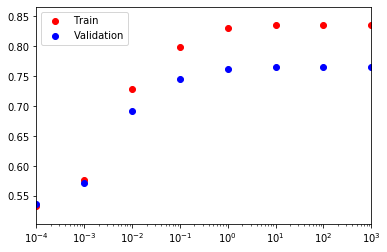

La mejor acuraccy para el conjunto de entrenamiento es de 0.8362681495211616


In [8]:
from sklearn.linear_model import LogisticRegression
import pylab
import matplotlib.pyplot as plt

def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression(penalty='l2',solver='saga',max_iter=50)
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    val_acc = model.score(xv,yv)
    return model, train_acc, val_acc

Cs = [10**i for i in range(-4,4)]
print(Cs)
list_train_acc = []
list_val_acc= []
for i in Cs:
    model, train_acc, val_acc = do_LOGIT(features_train,labels_train,features_val,labels_val, i)
    list_train_acc.append(train_acc)
    list_val_acc.append(val_acc)
#plt.plot(Cs,list_train_acc)

plt.scatter(Cs,list_train_acc, c='r', label='Train')
plt.scatter(Cs,list_val_acc, c= 'b', label='Validation')
plt.legend()
plt.xscale("log")
plt.xlim([10**-4,10**3])
plt.show()

print("La mejor acuraccy para el conjunto de entrenamiento es de",max(list_train_acc))

Se entrena el modelo utilizando regresión logística dado que fue el que presentó mejores resultados anteriormente. Además, se obtiene que utilizando un parametro "C" = 10 se consigue la mejor "accuracy", cuyo valor es de 0,84 aproximadamente. 



In [ ]:
from sklearn.svm import SVC as SVM #SVC is for classification
def do_SVM(x,y,xv,yv, param, kernel='linear'):
    print("Param C= ",param, 'Kernel= ', kernel)
    model= SVM()
    model.set_params(C=param,kernel=kernel) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

list_train_acc = []
list_test_acc = []
list2_train_acc = []
list2_test_acc = []

Cs = [10**i for i in np.arange(-4,4,dtype=float)]
for i in Cs:
    _, train_acc, test_acc = do_SVM(features_train,labels_train,features_val,labels_val,i,'linear')
    list_train_acc.append(train_acc)
    list_test_acc.append(test_acc)
    _, train_acc, test_acc = do_SVM(features_train,labels_train,features_val,labels_val,i,'rbf')
    list2_train_acc.append(train_acc)
    list2_test_acc.append(test_acc)

def plot(Name,Cs,lista1,lista2):
    plt.scatter(Cs,lista1,c='r',label='Train')
    plt.scatter(Cs,lista2,c='b',label='Val')
    pylab.legend(loc='upper left')
    plt.xscale("log")
    plt.xlim([10**-4,10**3])
    plt.title(Name)
    plt.show()

plot('Linear',Cs,list_train_acc,list_test_acc)
plot('Rbf',Cs,list2_train_acc,list2_test_acc)
print("La mejor acuraccy para Kernel Lineal es de",max(list_train_acc))
print("La mejor acuraccy para Kernel RBF es de ",max(list2_train_acc))

Se intenta ejecutar con SVM pero al ser una gran cantidad de datos tarda mas de 10 minutos en realizar todas las iteraciones, por lo que se descarto utilizarlo.

Param K=  1
0.7888991864895479
0.7198462277751081
Param K=  11
0.7364843991350015
0.6714320038443056
Param K=  21
0.6975079806405108
0.6558145122537242
Param K=  31
0.6839151477705695
0.6468044209514656
Param K=  41
0.6835032437442076
0.643320518981259
Param K=  51
0.6788693234476367
0.6415185007208073
Param K=  61
0.6682627947688189
0.6322681403171552
Param K=  71
0.6577077540932963
0.6226573762614128
Param K=  81
0.6472556894243642
0.615929841422393
Param K=  91
0.644114921223355
0.6118452666987025


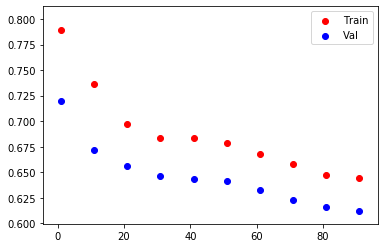

In [9]:
from sklearn.neighbors import KNeighborsClassifier
def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

Ks = np.arange(1, 100, 10) 
list_train_acc = []
list_test_acc = []
for i in Ks:
    _, train_acc, test_acc = do_KNN(features_train,labels_train,features_val,labels_val,i)
    list_train_acc.append(train_acc)
    list_test_acc.append(test_acc)
    print(train_acc)
    print(test_acc)

plt.scatter(Ks,list_train_acc,c='r',label='Train')
plt.scatter(Ks,list_test_acc,c='b',label='Val')
pylab.legend(loc='upper right')
plt.show()

En el conjunto de entrenamiento se puede observar que, a medida que aumenta la cantidad de vecinos involucrados en la clasificación, disminuye la accuracy. El motivo de esto es el mismo que fue descrito en la sección 1. La mejor acuraccy obtenida fue de 0.78 aproximadamente.


In [10]:
from sklearn.metrics import accuracy_score

#Se utiliza un modelo de Regresión logistica con los mejores parametros obtenidos según el gráfico.
model= LogisticRegression(penalty='l2',solver='saga',max_iter=50)
model.set_params(C=10)
#Se entrena utilizando el conjunto de entrenamiento
model.fit(features_train,labels_train)
#Se predicen los valores del conjunto de validación del dataframe
y_pred = model.predict(features_val)
#Se compara la predicción con los verdaderos valores de cada texto del conjunto de validación
print("Se obtiene un acuraccy score de",accuracy_score(true_labels_val, y_pred))

Se obtiene un acuraccy score de 0.861604997597309


C:\Users\diego\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


A partir de los resultados de los tres modelos anteriores, se aplica el modelo de Regresión Logística con parametro C=10, dado que es el mejor, para poder predecir el sentimiento de cada texto del conjunto de validación y luego se compara con el real (Input.true_sent) mediante la función de accuracy_score.

A partir del accuracy obtenido, se puede concluir que al utilizar la calificación de muchas personas inexpertas respecto al análisis sentimental de reseñas, se obtiene un modelo predictivo bastante preciso en comparación a la evaluación de un experto en el tema. Esto es ventajoso dado que se obtiene una aproximación bastante cercana sin los costos de reclutar a un experto y también al existir una mayor cantidad de personas inexpertas, es posible conseguir una mayor cantidad de datos etiquetados al venir estos de muchas fuente y no solo del reducido grupo de personas que son expertas en un dominio en particular. 
Otro punto importante a mencionar, es que el ámbito del análisis sentimental de una reseña tiene buenos resultados al ser evaluado por personas inexpertas, dado que es fácil de estimar para una persona común la intención detrás de una opinión. Sin embargo, en ámbitos donde se requiera conocimientos más refinados para etiquetar un dato sería más riesgoso el utilizar esta técnica y se podría esperar una accuracy menor.

<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews  
[3] https://en.wikipedia.org/wiki/Stopwords  
[4] https://en.wikipedia.org/wiki/Lemmatisation  
[5] Landauer, T. K., Foltz, P. W., & Laham, D. (1998). *An introduction to latent semantic analysis*. Discourse processes, 25(2-3), 259-284.  
[6] https://github.com/cjhutto/vaderSentiment  
[7] https://en.wikipedia.org/wiki/Stemming  
[8] Rodrigues, F., Pereira, F., & Ribeiro, B. (2013). *Learning from multiple annotators: distinguishing good from random labelers*. Pattern Recognition Letters, 34(12), 1428-1436.